In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr,probplot
from datetime import datetime
from sklearn.metrics import mean_squared_error 
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plPrice = pd.read_csv('plPrice17-19.csv')
plPrice.drop(columns = ['Hong Kong 8:30','Hong Kong 14:00','New York 9:30'],inplace = True)
plPrice.rename(columns = {'London 09:00':'Price'},inplace= True)
plPrice.dropna(how='any',inplace = True)
plPrice.to_csv('plPrice17-20Updated.csv')
plPrice['Date'] = pd.to_datetime(plPrice['Date'])
plPrice=plPrice[plPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]

In [4]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

simulatedFTSE = pd.read_csv('fullSimulatedFTSEPrice.csv')
simulatedFTSE.rename(columns = {'Unnamed: 0':'Date'},inplace = True)
simulatedFTSE['Date'] = pd.to_datetime(simulatedFTSE['Date'])


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [11]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    tilt = tilt.divide(100)
    
    for idx, quarter in enumerate(quarterNames):
        #print(quarter)
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        #print(stockWeightsOpen)
        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        #stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        #stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        #stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        #stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        
        totalMCsCloseLast = totalMCsClose['0'].iloc[-1]
        sumWeights = totalMCsOpen
        
        stockidx = 0
        
        for stock in FTSEStocksEachQuarter[quarter]:
            tiltStock = tilt.loc[stock][0]
            weightClose = stockWeightsClose[stock].iloc[-1]
            
            #applies tilt to weights and then sums new weights 
            #weight cannot be <0 
            if stockidx == 0:
                sumWeights = pd.Series([(-weight) if tiltStock+weight<0 else tiltStock + weight for weight in stockWeightsOpen[stock]])
                
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose = -weightClose
                else:
                    sumWeightsLastClose = tiltStock + weightClose
            else:
                sumWeights += pd.Series([(-weight) if tiltStock+weight<0 else tiltStock + weight for weight in stockWeightsOpen[stock]])
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose -= weightClose
                else:
                    sumWeightsLastClose += tiltStock + weightClose
           
            stockidx += 1
            
            
        #gets new market caps based off updated weights
        newTotalMarketCapsOpen = totalMCsOpen['0']* sumWeights
        #finds last closing mc of quarter for index divisor calc
        closeTotalMC = sumWeightsLastClose*totalMCsClose['0'].iloc[-1]
        
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/quarterClose
        #print(indexDivisorForQuarter,closeTotalMC)

        quarterClose = closeTotalMC / indexDivisorForQuarter
        #calculates new tilted price using index divisor and tilted market caps
        newTotalMarketCapsOpen = newTotalMarketCapsOpen.to_frame()
        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        #FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)

    FTSEPrice3yr.rename(columns={'0':"Open"}, inplace=True)
    
    return FTSEPrice3yr

Find pearson and spearman correlations between each stock and the palladium price for 2019

In [12]:
pearsonVals = []
spearmanVals = []
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

for stock in fullStockListDf['0'].values:
    if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
    else:
        stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
    stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
    stockPrice=stockPrice[stockPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
    stockPrice=stockPrice[stockPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]
    
    p = pearsonr(stockPrice['Open'].values,plPrice19['Price'].values)
    pearsonVals.append((p[0]))
    
    s = spearmanr(stockPrice['Open'].values,plPrice19['Price'].values) 
    
    spearmanVals.append((s[0]))

In [13]:
#Companies with highest correlations with palladium in 2019
corrCoeffs = pd.DataFrame({'Company':fullStockListDf['0'].values,'Pearson':pearsonVals,'Spearman':spearmanVals})
display(corrCoeffs[abs(corrCoeffs['Pearson'])>0.9])
display(corrCoeffs[abs(corrCoeffs['Spearman'])>0.9])

,Company,Pearson,Spearman
15,BKG,0.906581,0.836910
105,SVT,0.919766,0.901112


,Company,Pearson,Spearman
105,SVT,0.919766,0.901112


In [14]:
#Use stock correlations as weights for tilt function
optimalTiltsPearson = pd.DataFrame(index = fullStockListDf['0'].values,data = {'Pearson':[i * 2 for i in pearsonVals]})
optimalTiltsSpearman = pd.DataFrame(index = fullStockListDf['0'].values,data = {'Spearman':[i * 2 for i in spearmanVals]})

In [15]:
#Get tilted FTSE data
tiltedFTSESPearson = tiltFTSE(optimalTiltsPearson)
tiltedFTSESpearman = tiltFTSE(optimalTiltsSpearman)

In [9]:
#Use Pearson tilted FTSE for analysis
tiltedFTSE = tiltedFTSESPearson

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


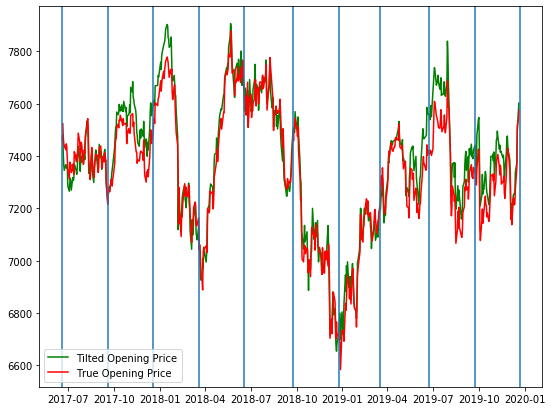

In [10]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
f.show()

Pearson CC between tilted FTSE and Pl price:  0.8391381996685626
Pearson CC between real FTSE price and Pl price:  0.35506803242085305
Pearson CC between simulated (untilted) FTSE and Pl price:  0.19712841527467906

Tilt MSE 31244914.94192716 
Simulated FTSE MSE 33226522.349319074 
Percentage improvement 5.963932627552049 %

Percentage Change correlation - tilted and pl 0.08897767357382999
Percentage Change correlation - untilted and pl 0.1123181879789101


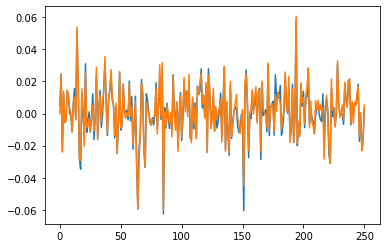

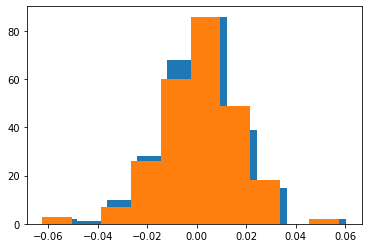

In [12]:
#Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
simulatedFTSE2019=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()) & (simulatedFTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date())]
FTSE2019=FTSE[(FTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()) & (FTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date())]

#Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
#

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE[0])

#correlation between real FTSE and pl price
correlationFTSE = pearsonr(FTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between real FTSE price and Pl price: ',correlationFTSE[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE = pearsonr(simulatedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between simulated (untilted) FTSE and Pl price: ',correlationSimFTSE[0])

#will only use simulated untilted FTSE price from now on

#Find mean squared error between pl price and tilted/simulated FTSE
mseTilt = mean_squared_error(plPrice19['Price'].values,tiltedFTSE2019['Open'].values)
mseSimu = mean_squared_error(plPrice19['Price'].values,simulatedFTSE2019['Open'].values)
print('\nTilt MSE',mseTilt,'\nSimulated FTSE MSE' ,mseSimu, '\nPercentage improvement',(1-mseTilt/mseSimu)*100,'%' )

#find daily percentage changes for tilted FTSE , untilted simulated and pl price
percentageChangeTilted = ((tiltedFTSE2019['Open'].shift(-1) / tiltedFTSE2019['Open']) - 1).reset_index()
percentageChangeSimuFTSE = ((simulatedFTSE2019['Open'].shift(-1) / simulatedFTSE2019['Open']) - 1).reset_index()
percentageChangePl = ((plPrice19['Price'].shift(-1) /  plPrice19['Price']) - 1).reset_index()

#find the difference in daily percentage change between pl price and both Tilted FTSE and simulated untilted FTSE
PCDiffTilt = (percentageChangePl['Price'][:-1] - percentageChangeTilted['Open'][:-1])
PCDiffSim = (percentageChangePl['Price'][:-1] - percentageChangeSimuFTSE['Open'][:-1])

#find corrleation between daily percentage changes for pl price and tilted FTSE
print('\nPercentage Change correlation - tilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeTilted['Open'][:-1])[0])
print('Percentage Change correlation - untilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeSimuFTSE['Open'][:-1])[0])

#plot of the daily percentage change difference between [pl and tilted] and [pl and untilted] 
plt.figure(1)
plt.plot(PCDiffTilt.index.values, PCDiffTilt)
plt.plot(PCDiffSim.index.values, PCDiffSim)

#histogram of daily percentage change difference
plt.figure(2)
plt.hist(PCDiffSim)
plt.hist(PCDiffTilt)
plt.show()


# moving average stuff
#movingAveragePCPl = percentageChangePl.rolling(5, min_periods=1).mean()
#movingAveragePCTilt = percentageChangeTilted.rolling(5, min_periods=1).mean()
#print(pearsonr(simulatedFTSE2019['Open'].values,FTSE2019['Open'].values))
#print('MA correlation', pearsonr(movingAveragePCPl,movingAveragePCTilt))

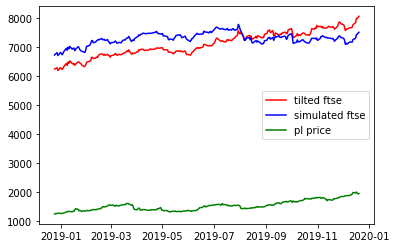

In [13]:
#plot of absolute tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].values, 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].values, 'g-' ,label = 'pl price')
plt.legend()
plt.show()

In [14]:
#Get only 2018 FTSE values for tilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
simulatedFTSE2018=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (simulatedFTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
FTSE2018=FTSE[(FTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (FTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y'))]

#get pl price for 2018
plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

#--------using FTSE tilted using weights trained on 2019---------

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE2018 = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE2018[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE2018 = pearsonr(simulatedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between simulated (untilted) FTSE price and Pl price: ',correlationSimFTSE2018[0])

#correlation between real FTSE and pl price
correlationFTSE2018 = pearsonr(FTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between real FTSE and Pl price: ',correlationFTSE2018[0])




Pearson CC between tilted FTSE and Pl price:  -0.6592641072639851
Pearson CC between simulated (untilted) FTSE price and Pl price:  -0.5305275937035294
Pearson CC between real FTSE and Pl price:  -0.5472277825446668


In [15]:
#input values array for ftse price and pl price
def LR_validity2(tilt_og, pl_og, f = None,axs = None,norm = True):
    if norm == True:
        tilt_og = tilt_og / np.mean(tilt_og)
        pl_og = pl_og / np.mean(pl_og)
    pl = pl_og
    tilt = tilt_og.reshape(-1, 1)
    lr = LinearRegression()
    lrmodel = lr.fit(tilt, pl)
    print('R-squared for model = ', lrmodel.score(tilt,pl), 'gradient = ',lrmodel.coef_, 'intercept = ',lrmodel.intercept_)
    colours = ['purple','mediumorchid']
    if f == None:
        f= plt.figure(figsize=(10,10))
        f.clf()
        axs = f.add_subplot(111)
        colours = ['seagreen','royalblue']
    axs.scatter(tilt, pl,c= colours[0])
    axs.tick_params(axis = 'x',labelsize = 14)
    axs.tick_params(axis = 'y',labelsize = 14)
    #axs.set_xlim((0.8,1.2))
    #axs.set_ylim((0.7,1.3))
    predictedPlPrice = lr.predict(tilt)
    extra = 0.01
    axs.plot([tilt.min()-extra,tilt.max()+extra], [(tilt.min()-extra)*lrmodel.coef_[0] + lrmodel.intercept_,(tilt.max()+extra)*lrmodel.coef_[0]+ lrmodel.intercept_],colours[1] , linewidth = 3)
    residuals = pl - predictedPlPrice
    return f,axs,residuals 

In [16]:
#input values array for ftse price and pl price
def LR_validity(tilt_og, pl_og, f = None,axs = None,norm = True):
    if norm == True:
        
        tilt_og = tilt_og / np.mean(tilt_og)
        pl_og = pl_og / np.mean(pl_og)
        colours = ['seagreen','royalblue']
    else:
        colours = ['purple','mediumorchid']
    pl = pl_og
    tilt = tilt_og.reshape(-1, 1)
    lr = LinearRegression()
    lrmodel = lr.fit(tilt, pl)
    print('R-squared for model = ', lrmodel.score(tilt,pl), 'gradient = ',lrmodel.coef_, 'intercept = ',lrmodel.intercept_)
    
    if f == None:
        f= plt.figure(figsize=(10,10))
        f.clf()
        axs = f.add_subplot(111)
        
    axs.scatter(tilt, pl,c= colours[0])
    axs.tick_params(axis = 'x',labelsize = 14)
    axs.tick_params(axis = 'y',labelsize = 14)
    #axs.set_xlim((0.8,1.2))
    #axs.set_ylim((0.7,1.3))
    predictedPlPrice = lr.predict(tilt)
    extra = 0.01
    axs.plot([tilt.min()-extra,tilt.max()+extra], [(tilt.min()-extra)*lrmodel.coef_[0] + lrmodel.intercept_,(tilt.max()+extra)*lrmodel.coef_[0]+ lrmodel.intercept_],colours[1] , linewidth = 3)
    residuals = pl - predictedPlPrice
    return f,axs,residuals 

R-squared for model =  0.4346291631265791 gradient =  [-1.40456009] intercept =  2.4045600895146313


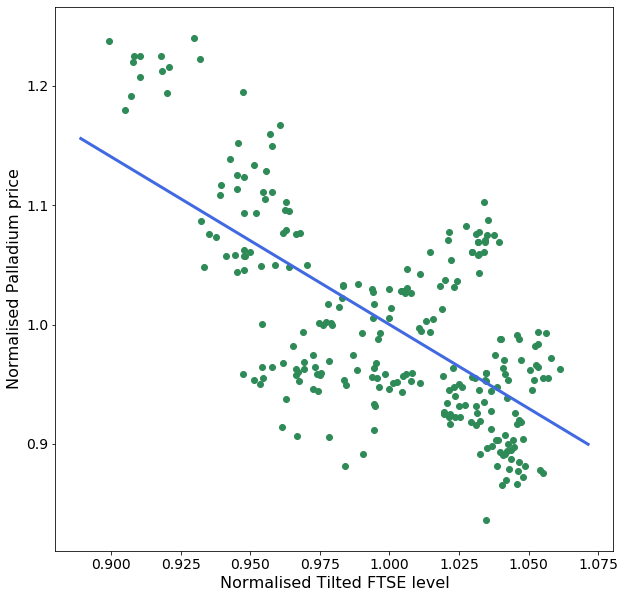

In [17]:
f,axs,residuals = LR_validity(tiltedFTSE2018['Open'].values, plPrice2018['Price'].values)
axs.set_xlabel('Normalised Tilted FTSE level',fontsize=16)
axs.set_ylabel('Normalised Palladium price',fontsize=16)

f.savefig('LRTilted18.png',dpi = 80)
#rint(residuals)
#plt.show()
#plt.hist(residuals)
#plt.show()



R-squared for model =  0.4346291631265791 gradient =  [-1.40456009] intercept =  2.4045600895146313


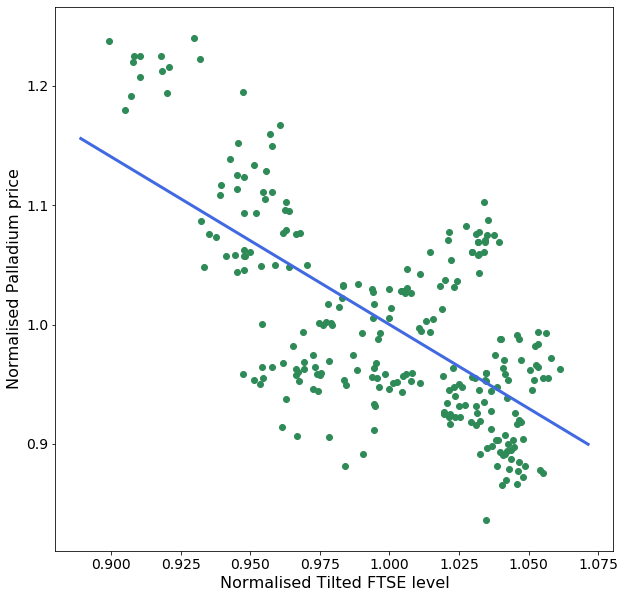

In [18]:
f,axs,residuals = LR_validity(tiltedFTSE2018['Open'].values, plPrice2018['Price'].values)
axs.set_xlabel('Normalised Tilted FTSE level',fontsize=16)
axs.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRTilted18.png',dpi = 80)

R-squared for model =  0.7041529181429966 gradient =  [1.56861816] intercept =  -0.5686181571964797


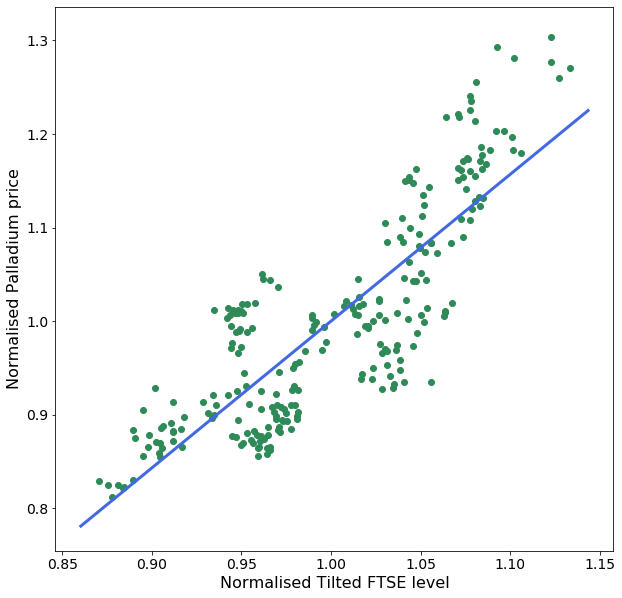

In [32]:
f,axs,residuals = LR_validity(tiltedFTSE2019['Open'].values, plPrice19['Price'].values)
axs.set_xlabel('Normalised Tilted FTSE level',fontsize=16)
axs.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRTilted19Norm.png',dpi = 80)
#plt.show()
#this oneprint(residuals)

#plt.hist(residuals)
#plt.show()


R-squared for model =  0.038859612108706365 gradient =  [0.17242803] intercept =  278.51002133178076


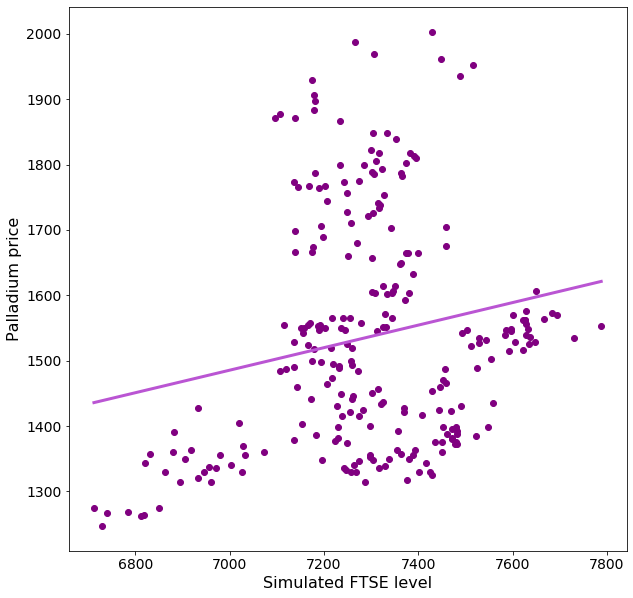

In [20]:
f= plt.figure(figsize=(10,10))
f.clf()
axes = f.add_subplot(111)

f,axes,residuals = LR_validity(simulatedFTSE2019['Open'].values, plPrice19['Price'].values,f=f,axs=axes,norm=False)
axes.set_xlabel('Simulated FTSE level',fontsize=16)
axes.set_ylabel('Palladium price',fontsize=16)
f.savefig('LRSim19.png',dpi=80)
plt.show()

R-squared for model =  0.038859612108706365 gradient =  [0.81873972] intercept =  0.18126028304431585


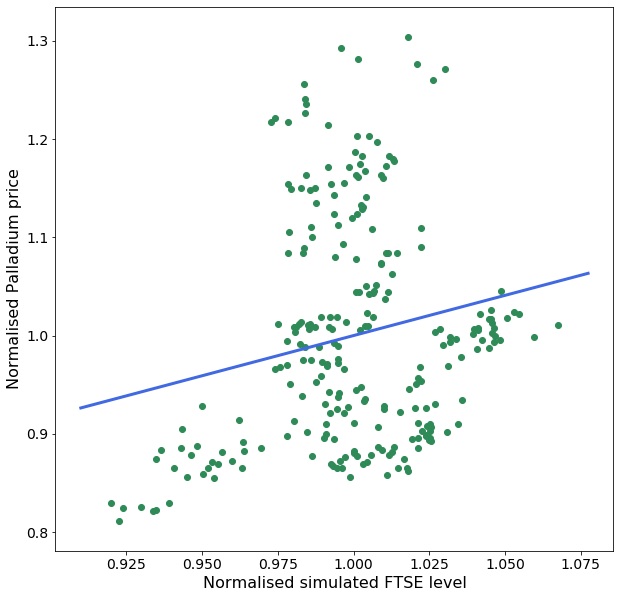

In [21]:
f,axes,residuals = LR_validity(simulatedFTSE2019['Open'].values, plPrice19['Price'].values,norm =True)
axes.set_xlabel('Normalised simulated FTSE level',fontsize=16)
axes.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRSim19Norm.png',dpi=80)

R-squared for model =  0.28145952768085725 gradient =  [-1.11527651] intercept =  2.115276511757064


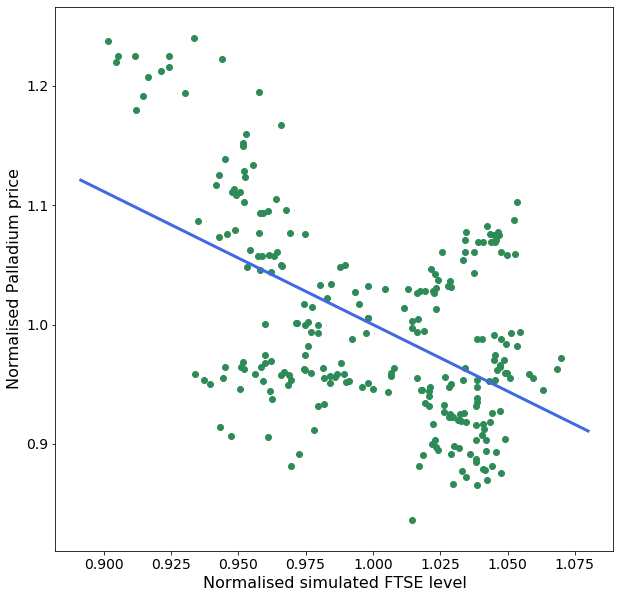

In [22]:
f,axes,residuals = LR_validity(simulatedFTSE2018['Open'].values, plPrice2018['Price'].values,norm =True)
axes.set_xlabel('Normalised simulated FTSE level',fontsize=16)
axes.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRSim18Norm.png',dpi=80)

R-squared for model =  0.038859612108706365 gradient =  [0.81873972] intercept =  0.18126028304431585
R-squared for model =  0.038859612108706365 gradient =  [0.17242803] intercept =  278.51002133178076


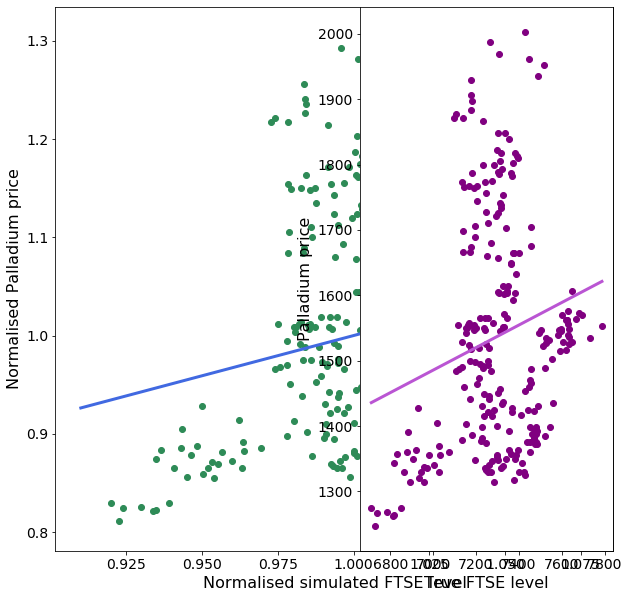

In [23]:
f,axes,residuals = LR_validity(simulatedFTSE2019['Open'].values, plPrice19['Price'].values)
axes.set_xlabel('Normalised simulated FTSE level',fontsize=16)
axes.set_ylabel('Normalised Palladium price',fontsize=16)
axes2 = f.add_subplot(122)
f,axs,residuals = LR_validity(simulatedFTSE2019['Open'].values, plPrice19['Price'].values,f,axes2,norm=False)
axes2.set_xlabel('True FTSE level',fontsize=16)
axes2.set_ylabel('Palladium price',fontsize=16)
#f.suptitle('Linear Model between Palladium price and sim')
f.savefig('LRNormSim19.png',dpi = 80)
#plt.show()
#print(residuals)

#plt.hist(residuals)
#plt.show()

R-squared for model =  0.12607330764721592 gradient =  [1.47098108] intercept =  -0.470981081880522


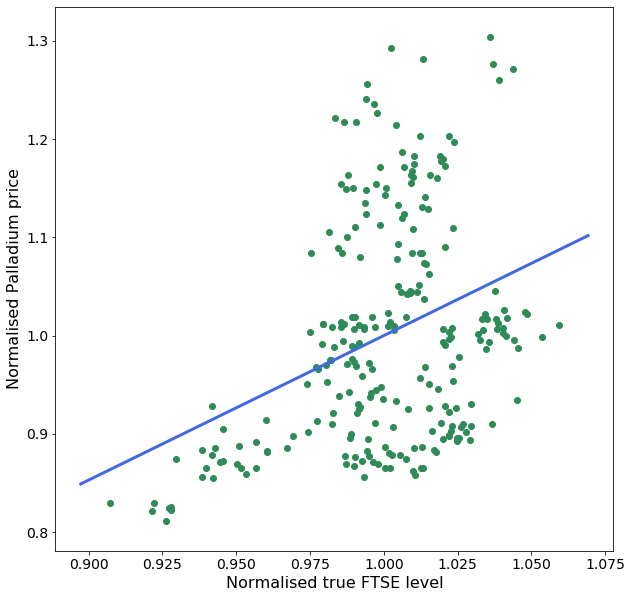

In [24]:
f,axes,residuals = LR_validity(FTSE2019['Open'].values, plPrice19['Price'].values)
axes.set_xlabel('Normalised true FTSE level',fontsize=16)
axes.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRTrue19Norm.png',dpi=80)


R-squared for model =  0.2994582459887529 gradient =  [-1.18095154] intercept =  2.1809515358644873


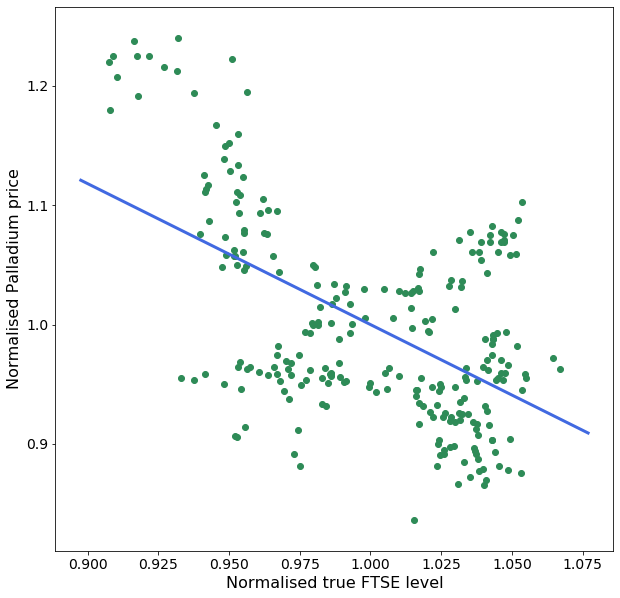

In [25]:
f,axes,residuals = LR_validity(FTSE2018['Open'].values, plPrice2018['Price'].values)
axes.set_xlabel('Normalised true FTSE level',fontsize=16)
axes.set_ylabel('Normalised Palladium price',fontsize=16)
f.savefig('LRTrue18Norm.png',dpi=80)


R-squared for model =  0.12607330764721603 gradient =  [0.31144456] intercept =  -723.671777172158


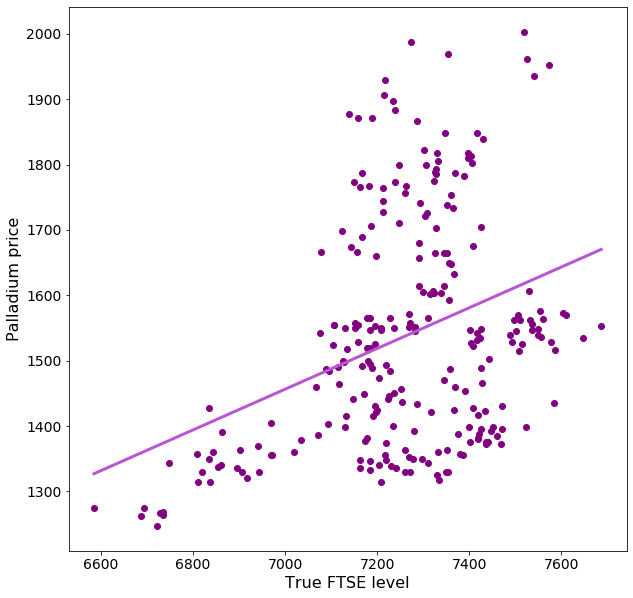

In [26]:

f= plt.figure(figsize=(10,10))
f.clf()
axes = f.add_subplot(111)

f,axes,residuals = LR_validity(FTSE2019['Open'].values, plPrice19['Price'].values,f=f,axs=axes,norm=False)
axes.set_xlabel('True FTSE level',fontsize=16)
axes.set_ylabel('Palladium price',fontsize=16)
f.savefig('LRTrue19.png',dpi=80)
plt.show()

R-squared for model =  0.7041529181429966 gradient = 

R-squared for model =  0.038859612108706365

R-squared for model =  0.12607330764721603

R-squared for model =  0.4346291631265794


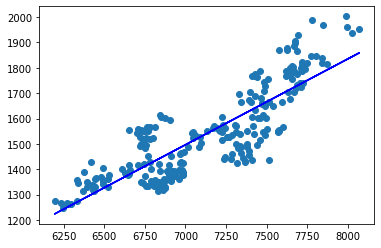

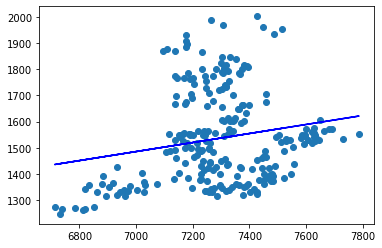

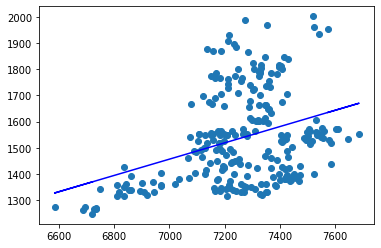

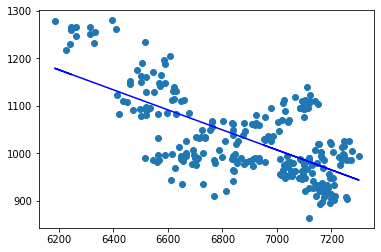

In [27]:
lr = LinearRegression()
lrTilted = lr.fit(tiltedFTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values)
print('R-squared for model = ', lrTilted.score(tiltedFTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values),'gradient = ',)
plt.scatter(tiltedFTSE2019['Open'].values, plPrice19['Price'].values)
plt.plot(tiltedFTSE2019['Open'].values, lr.predict(tiltedFTSE2019['Open'].values[:, np.newaxis]), 'b-')


plt.figure(2)
lrUnTilted = lr.fit(simulatedFTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values)
print('\nR-squared for model = ',lrUnTilted.score(simulatedFTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values))
plt.scatter(simulatedFTSE2019['Open'].values, plPrice19['Price'].values)
plt.plot(simulatedFTSE2019['Open'].values, lr.predict(simulatedFTSE2019['Open'].values[:, np.newaxis]), 'b-')


plt.figure(3)
lrTrueFTSE = lr.fit(FTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values)
print('\nR-squared for model = ',lrTrueFTSE.score(FTSE2019['Open'].values[:, np.newaxis], plPrice19['Price'].values))
plt.scatter(FTSE2019['Open'].values, plPrice19['Price'].values)
plt.plot(FTSE2019['Open'].values, lr.predict(FTSE2019['Open'].values[:, np.newaxis]), 'b-')


tiltedFTSE2018

plt.figure(4)
lrTilted2018 = lr.fit(tiltedFTSE2018['Open'].values[:, np.newaxis], plPrice2018['Price'].values)
print('\nR-squared for model = ',lrTilted2018.score(tiltedFTSE2018['Open'].values[:, np.newaxis], plPrice2018['Price'].values))
plt.scatter(tiltedFTSE2018['Open'].values, plPrice2018['Price'].values)
plt.plot(tiltedFTSE2018['Open'].values, lr.predict(tiltedFTSE2018['Open'].values[:, np.newaxis]), 'b-')
plt.show()

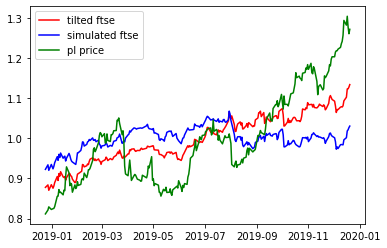

In [28]:
#plot of normalised tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].divide(tiltedFTSE2019['Open'].mean()).values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].divide(simulatedFTSE2019['Open'].mean()), 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].divide(plPrice19['Price'].mean()), 'g-' ,label = 'pl price')
plt.legend()
plt.show()

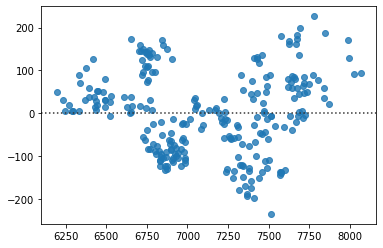

In [29]:
sns.residplot(tiltedFTSE2019['Open'].values, plPrice19['Price'].values, order = 1)
plt.show()

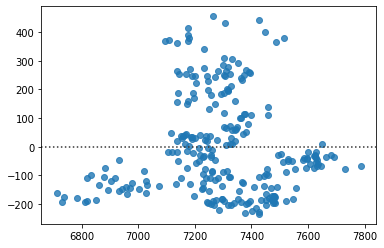

In [30]:
sns.residplot(simulatedFTSE2019['Open'].values, plPrice19['Price'].values,order=1)
plt.show()